# Clustering Analysis

In [1]:
# import packages
import numpy as np
import pandas as pd
from sklearn import cluster
from matplotlib import pyplot as plt
from sklearn import mixture
from pandas.plotting import radviz
from sklearn.decomposition import PCA
import plotly.express as px

In [2]:
# import data
# csv file
df = pd.read_excel('data/res3.0.xlsx')
# json file
#df = pd.read_json()

In [4]:
MF_scores = df[['c1','c2', 'c3_grade', 'c4_grade', 'c5grade', 'c7_grade']]

In [5]:
MF_scores.rename(columns={'c1':'Itme1', 'c2':'Item2', 'c3_grade':'Itme3', 'c4_grade':'Itme4', 'c5grade':'Item5', 'c7_grade':'Item7'}, inplace=True)

C:\Users\Simin Zuo\AppData\Local\Temp\ipykernel_25060\951541075.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MF_scores.rename(columns={'c1':'Itme1', 'c2':'Item2', 'c3_grade':'Itme3', 'c4_grade':'Itme4', 'c5grade':'Item5', 'c7_grade':'Item7'}, inplace=True)


In [3]:
full_data = df[['c1','c2', 'c3_grade', 'c4_grade', 'c5grade', 'c7_grade', 'final_grade_level']].copy()
full_data.replace (to_replace=r'^\s*$',value=np.nan,regex=True,inplace=True)
full_data = full_data.dropna()
dummy_grade_level = []
for i in full_data.final_grade_level:
    if i == 'H1':
        l = 1
    elif i == 'H2A':
        l = 2
    elif i == 'H2B':
        l = 3
    elif i == 'H3':
        l = 4
    else:
        l = 5
    dummy_grade_level.append(l)
full_data['dummy_grade_level'] = dummy_grade_level
full_data.pop('final_grade_level')
print(full_data.shape)
full_data.head()

(90, 7)


,c1,c2,c3_grade,c4_grade,c5grade,c7_grade,dummy_grade_level
0,0,3,0,0,0,0,2
1,0,3,0,0,0,0,3
2,0,2,0,0,0,0,4
3,0,3,0,0,0,0,1
4,1,3,0,0,0,1,3


In [32]:
full_data.columns

Index(['c1', 'c2', 'c3_grade', 'c4_grade', 'c5grade', 'c7_grade',
       'dummy_grade_level'],
      dtype='object')

In [29]:
def display(function):
    model = function
    print(model.labels_)
    n_clusters_ = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
    n_noise_ = list(model.labels_).count(-1)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    return

In [30]:
def classify(data, labels, file):
    dic = {}
    for i in range(len(labels)):
        if labels[i] in dic:
            dic[labels[i]].append(data.iloc[i,:])
        else:
            dic[labels[i]] = [data.iloc[i,:]]
    for key,val in dic.items():
        dic[key] = pd.DataFrame(val)
        print(f'Cluster {key}:')
        print(dic[key].describe())
        dic[key].describe().to_csv(f'Clustering/{file}/Cluster {key}.csv')
    return

In [42]:
def pca(data,labels, dimension=4):
    # data preparation
    y = pd.DataFrame([str(i) for i in labels])
    x = data
    # PCA
    pca = PCA()
    components = pca.fit_transform(x)
    label = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }
    fig = px.scatter_matrix(
        components,
        labels=label,
        dimensions=range(dimension),
        color=y
    )
    fig.update_traces(diagonal_visible=False)
    fig.show()
    return

Calculate inner group sum of square

In [81]:
def within_group_square(full_data,clustering):
    data = full_data.copy()
    data['cluster'] = clustering
    clusters = list(set(clustering))
    classifer = {}
    for c in clusters:
        classifer[c] = []
        for i in range(data.shape[0]):
            if data.iloc[i,6] == c:
                classifer[c].append(data.iloc[i,:].tolist())
    sumVar = {}
    for key,item in classifer.items():
        item = np.array(item)
        if len(item) > 0:
            var = 0
            for j in range(item.shape[1]):
                var += np.var(item[:,j])
            sumVar[key] = var
        else:
            sumVar[key] = 0
    totalVar = 0
    for val in sumVar.values():
        totalVar += val
    return totalVar/len(sumVar.keys())

# Cluster methods

In [19]:
### Affinity Propagation
#Do not need to determine number of clusters
def affi_prop(X, damping=0.9):
    # define model
    model = cluster.AffinityPropagation(damping=damping,random_state=5)
    # fit model
    model.fit(X)
    # predict
    yhat = model.predict(X)
    return model


### DBSCAN
#DBSCAN relies on cluster design based on the concept of density to discover clusters of arbitrary shape
def DBSCAN(X, eps=0.30, min_samples=9):
    # define model
    model = cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    #clusters = unique(yhat)
    return model


### Mean Shift
def meanShift(X, bandwidth=2):
    # define model
    model = cluster.MeanShift(bandwidth=bandwidth).fit(X)
    return model


### Mini Batch K Means
#It’s a modified version of k-means and suitable for small sample size datasets
def miniBatch(X, n_clusters=3):
    # define model
    model = cluster.MiniBatchKMeans(n_clusters=n_clusters).fit(X)
    return model


### BIRCH
#It is used for uneven cluster sizes
def birch(X, threshold=0.01, n_clusters=2):
    # define model
    model = cluster.Birch(threshold=threshold, n_clusters=n_clusters).fit(X)
    return model

# other methods

In [18]:
### Spectral
#medium number of clusters
#Suitable for clusters of different sizes
def Spectral(X, n_clusters=2):
    # define model
    model = cluster.SpectralClustering(n_clusters=n_clusters).fit(X)
    return model


### Gaussian Mixture
def GaussianMixture(X, n_clusters=2):
    # define model
    model = mixture.GaussianMixture(n_components=n_clusters).fit(X)
    return model

# Training and tuning

In [34]:
#### Affinity Propagation
def aff(data):
    num_clu = []
    num_noise = []
    d = np.arange(0.5,0.68,0.01)
    for i in d:
        model = affi_prop(data, damping=i)
        n_clusters_ = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
        num_clu.append(n_clusters_)
        n_noise_ = list(model.labels_).count(-1)
        num_noise.append(n_noise_)

    fig, ax = plt.subplots()
    ax.scatter(d, num_clu, linewidth=2.0)
    ax.set(xlim=(0.6, 0.7))
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(d, num_noise, linewidth=2.0)
    ax.set(xlim=(0.6, 0.7))
    plt.show()
    return

In [ ]:
aff(MF_scores)

D:\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:246: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
D:\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:460: ConvergenceWarning: This model does not have any cluster centers because affinity propagation did not converge. Labeling every sample as '-1'.
  warnings.warn("This model does not have any cluster centers "
D:\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:246: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
D:\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:460: ConvergenceWarning: This model does not have any cluster centers because affinity propagation did not converge. Labeling every sample as 

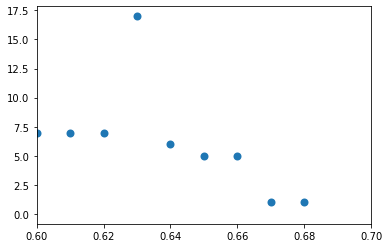

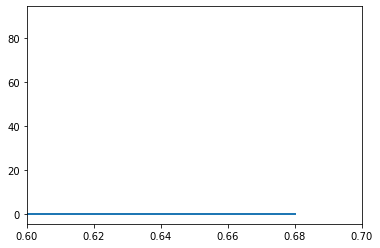

In [35]:
aff(full_data)

In [37]:
classify(full_data, affi_prop(full_data, damping=0.65).labels_, 'affi_prop')

Cluster 2:
              c1         c2  c3_grade  c4_grade    c5grade   c7_grade  \
count  27.000000  27.000000      27.0      27.0  27.000000  27.000000   
mean    0.111111   2.814815       0.0       0.0   0.185185   0.037037   
std     0.320256   0.483341       0.0       0.0   0.483341   0.192450   
min     0.000000   1.000000       0.0       0.0   0.000000   0.000000   
25%     0.000000   3.000000       0.0       0.0   0.000000   0.000000   
50%     0.000000   3.000000       0.0       0.0   0.000000   0.000000   
75%     0.000000   3.000000       0.0       0.0   0.000000   0.000000   
max     1.000000   3.000000       0.0       0.0   2.000000   1.000000   

       dummy_grade_level  
count          27.000000  
mean            1.148148  
std             0.362014  
min             1.000000  
25%             1.000000  
50%             1.000000  
75%             1.000000  
max             2.000000  
Cluster 0:
              c1         c2  c3_grade  c4_grade  c5grade  c7_grade  \
count  

D:\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:246: ConvergenceWarning:

Affinity propagation did not converge, this model will not have any cluster centers.

D:\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:460: ConvergenceWarning:

This model does not have any cluster centers because affinity propagation did not converge. Labeling every sample as '-1'.

D:\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:246: ConvergenceWarning:

Affinity propagation did not converge, this model will not have any cluster centers.

D:\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:460: ConvergenceWarning:

This model does not have any cluster centers because affinity propagation did not converge. Labeling every sample as '-1'.

D:\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:246: ConvergenceWarning:

Affinity propagation did not converge, this model will not have any cluster centers.

D:\a

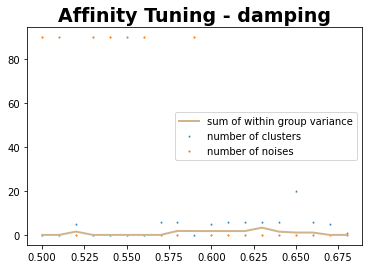

In [102]:
re = []
num_clu = []
num_noise = []
tuner = np.arange(0.5,0.68,0.01)
for damping in tuner:
    re.append(within_group_square(full_data,affi_prop(full_data, damping=damping).labels_))
    model = affi_prop(data, damping=damping)
    n_clusters_ = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
    num_clu.append(n_clusters_)
    n_noise_ = list(model.labels_).count(-1)
    num_noise.append(n_noise_)

plt.plot(tuner, re, linewidth=2, color='tan', label="sum of within group variance")
plt.scatter(tuner, num_clu, s=1, marker="^", label="number of clusters")
plt.scatter(tuner, num_noise, s=1, marker="D", label="number of noises")
plt.legend(loc="best")
plt.title("Affinity Tuning - damping", fontsize=19, weight="bold")
# plt.xlabel("This is x axis", fontsize=20, weight="bold")
# plt.ylabel("This is y axis")
plt.savefig("./demo-2.svg", dpi=400, bbox_inches="tight")
plt.show()

In [50]:
def pca(data,labels, dimension=4):
    # data preparation
    y = [str(i) for i in labels]
    x = data
    # PCA
    pca = PCA()
    components = pca.fit_transform(x)
    label = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }
    fig = px.scatter_matrix(
        components,
        labels=label,
        dimensions=range(dimension),
        color=y
    )
    fig.update_traces(diagonal_visible=False)
    fig.show()
    return

In [104]:
pca(full_data, affi_prop(full_data, damping=0.64).labels_, 3)

D:\anaconda3\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



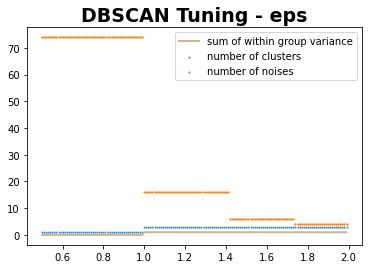

In [99]:
### DBSCAN
re = []
num_clu = []
num_noise = []
tuner = np.arange(0.5,2,0.01)
for eps in tuner:
    re.append(within_group_square(full_data,DBSCAN(full_data, eps=eps, min_samples=10).labels_))
    model = DBSCAN(full_data, eps=eps, min_samples=10)
    n_clusters_ = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
    num_clu.append(n_clusters_)
    n_noise_ = list(model.labels_).count(-1)
    num_noise.append(n_noise_)

plt.plot(tuner, re, linewidth=2, color='tan', label="sum of within group variance")
plt.scatter(tuner, num_clu, s=1, marker="^", label="number of clusters")
plt.scatter(tuner, num_noise, s=1, marker="D", label="number of noises")
plt.legend(loc="best")
plt.title("DBSCAN Tuning - eps", fontsize=19, weight="bold")
# plt.xlabel("This is x axis", fontsize=20, weight="bold")
# plt.ylabel("This is y axis")
plt.savefig("./demo-2.svg", dpi=400, bbox_inches="tight")
plt.show()

In [74]:
classify(full_data, DBSCAN(full_data, eps=1.4, min_samples=10).labels_, 'DBSCAN')

Cluster 0:
              c1         c2  c3_grade  c4_grade    c5grade  c7_grade  \
count  37.000000  37.000000      37.0      37.0  37.000000      37.0   
mean    0.054054   2.675676       0.0       0.0   0.081081       0.0   
std     0.229243   0.579945       0.0       0.0   0.276725       0.0   
min     0.000000   1.000000       0.0       0.0   0.000000       0.0   
25%     0.000000   2.000000       0.0       0.0   0.000000       0.0   
50%     0.000000   3.000000       0.0       0.0   0.000000       0.0   
75%     0.000000   3.000000       0.0       0.0   0.000000       0.0   
max     1.000000   3.000000       0.0       0.0   1.000000       0.0   

       dummy_grade_level  
count          37.000000  
mean            1.837838  
std             1.166988  
min             1.000000  
25%             1.000000  
50%             1.000000  
75%             3.000000  
max             4.000000  
Cluster -1:
              c1         c2  c3_grade   c4_grade    c5grade   c7_grade  \
count  16.0

In [24]:
pca(full_data, DBSCAN(full_data, eps=1.4, min_samples=10).labels_)

C:\Users\Simin Zuo\AppData\Local\Temp\ipykernel_25060\3336420842.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



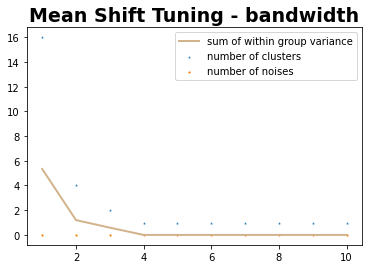

In [100]:
### Mean Shift
re = []
num_clu = []
num_noise = []
tuner = np.arange(1,11)
for bandwidth in tuner:
    re.append(within_group_square(full_data,meanShift(full_data, bandwidth=bandwidth).labels_))
    model = meanShift(full_data, bandwidth)
    n_clusters_ = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
    num_clu.append(n_clusters_)
    n_noise_ = list(model.labels_).count(-1)
    num_noise.append(n_noise_)

plt.plot(tuner, re, linewidth=2, color='tan', label="sum of within group variance")
plt.scatter(tuner, num_clu, s=1, marker="^", label="number of clusters")
plt.scatter(tuner, num_noise, s=1, marker="D", label="number of noises")
plt.legend(loc="best")
plt.title("Mean Shift Tuning - bandwidth", fontsize=19, weight="bold")
# plt.xlabel("This is x axis", fontsize=20, weight="bold")
# plt.ylabel("This is y axis")
plt.savefig("./demo-2.svg", dpi=400, bbox_inches="tight")
plt.show()

In [86]:
classify(full_data,meanShift(full_data, bandwidth=3).labels_, 'meanShift')

Cluster 1:
              c1         c2  c3_grade  c4_grade    c5grade   c7_grade  \
count  45.000000  45.000000      45.0      45.0  45.000000  45.000000   
mean    0.200000   2.622222       0.0       0.0   0.222222   0.088889   
std     0.547723   0.716332       0.0       0.0   0.559581   0.358166   
min     0.000000   0.000000       0.0       0.0   0.000000   0.000000   
25%     0.000000   2.000000       0.0       0.0   0.000000   0.000000   
50%     0.000000   3.000000       0.0       0.0   0.000000   0.000000   
75%     0.000000   3.000000       0.0       0.0   0.000000   0.000000   
max     3.000000   3.000000       0.0       0.0   2.000000   2.000000   

       dummy_grade_level  
count          45.000000  
mean            2.000000  
std             1.261312  
min             1.000000  
25%             1.000000  
50%             1.000000  
75%             3.000000  
max             5.000000  
Cluster 0:
              c1         c2  c3_grade   c4_grade    c5grade   c7_grade  \
cou

In [87]:
pca(full_data,meanShift(full_data, bandwidth=3).labels_)

D:\anaconda3\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1

D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1

D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1

D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning:

MiniBatchKMean

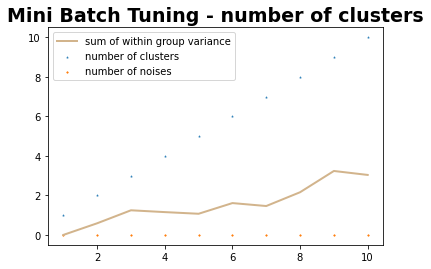

In [101]:
### Mini Batch K Means
re = []
num_clu = []
num_noise = []
tuner = np.arange(1,11)
for nclu in tuner:
    re.append(within_group_square(full_data,miniBatch(full_data, nclu).labels_))
    model = miniBatch(full_data, nclu)
    n_clusters_ = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
    num_clu.append(n_clusters_)
    n_noise_ = list(model.labels_).count(-1)
    num_noise.append(n_noise_)

plt.plot(tuner, re, linewidth=2, color='tan', label="sum of within group variance")
plt.scatter(tuner, num_clu, s=1, marker="^", label="number of clusters")
plt.scatter(tuner, num_noise, s=1, marker="D", label="number of noises")
plt.legend(loc="best")
plt.title("Mini Batch Tuning - number of clusters", fontsize=19, weight="bold")
# plt.xlabel("This is x axis", fontsize=20, weight="bold")
# plt.ylabel("This is y axis")
plt.savefig("./demo-2.svg", dpi=400, bbox_inches="tight")
plt.show()

In [107]:
classify(full_data,miniBatch(full_data, 2).labels_, 'miniBatch')

Cluster 1:
              c1         c2  c3_grade  c4_grade    c5grade   c7_grade  \
count  46.000000  46.000000      46.0      46.0  46.000000  46.000000   
mean    0.260870   2.630435       0.0       0.0   0.260870   0.108696   
std     0.681005   0.710515       0.0       0.0   0.612274   0.378785   
min     0.000000   0.000000       0.0       0.0   0.000000   0.000000   
25%     0.000000   2.250000       0.0       0.0   0.000000   0.000000   
50%     0.000000   3.000000       0.0       0.0   0.000000   0.000000   
75%     0.000000   3.000000       0.0       0.0   0.000000   0.000000   
max     3.000000   3.000000       0.0       0.0   2.000000   2.000000   

       dummy_grade_level  
count          46.000000  
mean            2.000000  
std             1.247219  
min             1.000000  
25%             1.000000  
50%             1.000000  
75%             3.000000  
max             5.000000  
Cluster 0:
              c1         c2  c3_grade   c4_grade    c5grade   c7_grade  \
cou

D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1



In [84]:
pca(full_data,miniBatch(full_data, 2).labels_,4)

D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1

D:\anaconda3\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



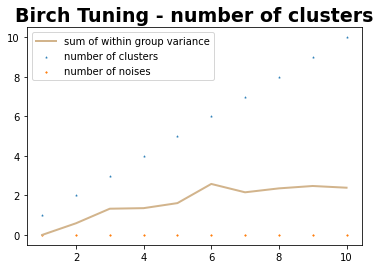

In [97]:
#### birch
re = []
num_clu = []
num_noise = []
tuner = np.arange(1,11)
for nclu in tuner:
    re.append(within_group_square(full_data,birch(full_data, n_clusters=nclu).labels_))
    model = birch(full_data, n_clusters=nclu)
    n_clusters_ = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
    num_clu.append(n_clusters_)
    n_noise_ = list(model.labels_).count(-1)
    num_noise.append(n_noise_)

plt.plot(tuner, re, linewidth=2, color='tan', label="sum of within group variance")
plt.scatter(tuner, num_clu, s=1, marker="^", label="number of clusters")
plt.scatter(tuner, num_noise, s=1, marker="D", label="number of noises")
plt.legend(loc="best")
plt.title("Birch Tuning - number of clusters", fontsize=19, weight="bold")
# plt.xlabel("This is x axis", fontsize=20, weight="bold")
# plt.ylabel("This is y axis")
plt.savefig("./demo-2.svg", dpi=400, bbox_inches="tight")
plt.show()

In [105]:
full_data.to_csv('full_Data.csv')

In [106]:
classify(full_data,birch(full_data, n_clusters=2).labels_, 'birch')

Cluster 0:
              c1         c2  c3_grade  c4_grade    c5grade   c7_grade  \
count  46.000000  46.000000      46.0      46.0  46.000000  46.000000   
mean    0.260870   2.630435       0.0       0.0   0.260870   0.108696   
std     0.681005   0.710515       0.0       0.0   0.612274   0.378785   
min     0.000000   0.000000       0.0       0.0   0.000000   0.000000   
25%     0.000000   2.250000       0.0       0.0   0.000000   0.000000   
50%     0.000000   3.000000       0.0       0.0   0.000000   0.000000   
75%     0.000000   3.000000       0.0       0.0   0.000000   0.000000   
max     3.000000   3.000000       0.0       0.0   2.000000   2.000000   

       dummy_grade_level  
count          46.000000  
mean            2.000000  
std             1.247219  
min             1.000000  
25%             1.000000  
50%             1.000000  
75%             3.000000  
max             5.000000  
Cluster 1:
              c1         c2  c3_grade   c4_grade    c5grade   c7_grade  \
cou

In [95]:
pca(full_data,birch(full_data, n_clusters=2).labels_)

D:\anaconda3\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


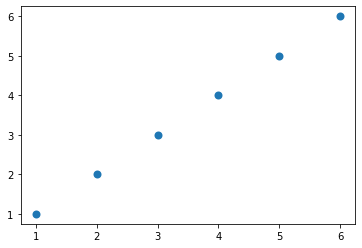

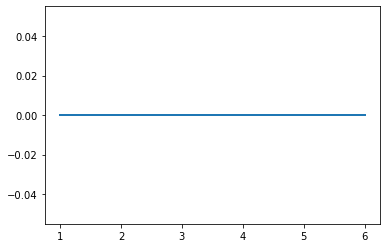

In [100]:
#### Spectral
c = range(1,7)
num_clu = []
num_noise = []
for i in c:
    model = Spectral(MF_scores, i)
    n_clusters_ = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
    num_clu.append(n_clusters_)
    n_noise_ = list(model.labels_).count(-1)
    num_noise.append(n_noise_)

fig, ax = plt.subplots()
ax.scatter(c, num_clu, linewidth=2.0)
plt.show()

fig, ax = plt.subplots()
ax.plot(c, num_noise, linewidth=2.0)
plt.show()